In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
R = 0.5
T_init = 34

In [3]:
def dxdt(t, x, u, t_eval):
    u = np.interp(t, t_eval, u)
    return R * (u - x)

def solve_ode(u_values, x0, t_span, t_eval):
    sol = solve_ivp(dxdt, t_span, x0, t_eval=t_eval, args=(u_values, t_eval))
    return sol

def discretized_solution(x_k, u_k, dt):
    return x_k + R * (u_k - x_k) * dt

In [4]:
def u(t):
    if t < 2:
        return 4
    elif t < 4:
        return 12
    elif t < 6:
        return 46
    elif t < 8:
        return 30
    elif t < 10:
        return 20

In [5]:
t_span = (0, 10)
dt = 0.001
t_eval = np.arange(t_span[0], t_span[1], dt)
# u_values = [45 for _ in t_eval]
u_values = [u(t) for t in t_eval]

numerical_sol = solve_ode(u_values, [T_init], t_span, t_eval)

discr_sol = []
x0 = T_init
for t in range(1, len(t_eval)):
    x_k = discretized_solution(x0, u_values[t], dt)
    discr_sol.append(x_k)
    x0 = x_k

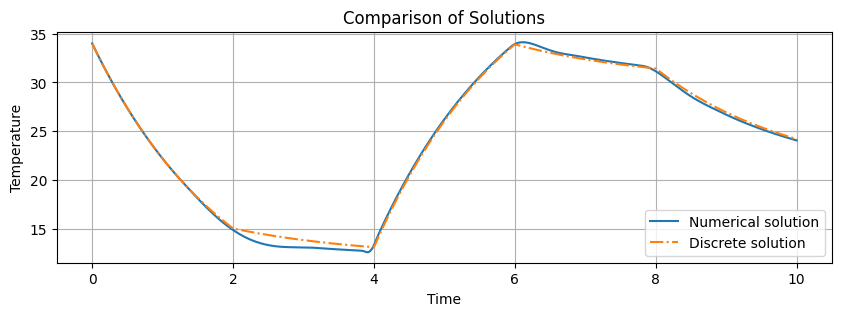

In [6]:
# Plot the results
plt.figure(figsize=(10, 3))
plt.plot(t_eval, numerical_sol.y[0], label='Numerical solution', linestyle='-')
plt.plot(t_eval[1:], discr_sol, label='Discrete solution', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Comparison of Solutions')
plt.legend()
plt.grid(True)
plt.show()


### Model Predictive Control

In [13]:
Np = 10
rho = 0.1

N = 25  # Prediction horizon (number of time steps in the future to optimize)
T_desired = 50  # Desired temperature
u_min = 0  # Minimum control input (could be heating/cooling rate)
u_max = 50  # Maximum control input (could be heating/cooling rate)

dt = 0.1  # Time step
time_range = 10 # Simulation time
L = round(time_range / dt)  # Simulation steps
time = 0 # Init time
x0 = 0 # Initial state

In [ ]:
def mpc_cost(u_seq, u_ini, x_ref, x0, dt):
    cost = 0
    x_k = x0
    for j in range(Np): # Prediction horizon
        # Compute and update the x_k
        x_k = discretized_solution(x_k, u_seq[j], dt)
        # Update cost
        cost += (x_ref - x_k) ** 2 + rho * (u_seq[j] - u_ini[j]) ** 2
    return cost

def solve_mpc(x_ref, x_k, u_ini, dt):
    # Starting optimization point for x are the current measurement
    x0 = x_k
    # Minimization
    result = minimize(mpc_cost, u_ini, args=(u_ini, x_ref, x0, dt))
    # Extract the optimal control input
    u_mpc = result.x
    return u_mpc

# ---------- SIMULATION INITIALISATION ----------
# Arrays for logging
x_log = np.zeros(L+1)
u_log = np.zeros(L)
x_ref = np.zeros(L)
# Init arrays to initial state
x_log[0] = x0

# ---------- CONTROL SYSTEM CALIBRATION ----------
# Array for initial solution for MPC
u_ini = np.zeros(Np)
# Array for values of x and u for each simulation
x_sim = []
u_sim = []

# ---------- SIMULATION LOOP ----------
for j in range(L):
    # Generate reference set point
    if time < 5:
        x_ref[j] = 15
    else:
        x_ref[j] = 25
        
    # Increment time 
    time += dt
    
    # --------- Control system loop --------------
    # Find optimal sequence for the next N steps
    u_mpc = solve_mpc(x_ref[j], x_log[j], u_ini, dt)
    
    # Use first element of control input optimal solution
    u_log[j] = u_mpc[0]
    
    # Initial solution for next step = current solution
    u_ini = u_mpc
    
    # ------------ Simulation loop ----------
    x_log[j+1] = discretized_solution(x_log[j], u_log[j], dt)


In [8]:
def objective(x0, u, sp):
    cost = 0
    x = x0
    for j in range(1, Np):
        x = discretized_solution(x, u[j], dt)
        cost += (x - sp)**2
        cost += rho * u[j]**2
    return cost

def mpc_control(x0, T_desired, dt, N, u_min, u_max):
    u0 = np.ones(N)
    result = minimize(objective, u0, args=(x0, dt, N, T_desired), bounds=[(u_min, u_max)]*N)
    if result.success:
        return result.x[0]  # Return the first control input
    else:
        print("Optimization failed!")
        return 0  # Default return if optimization fails
    
def simulate_mpc(N, dt, T_desired, u_min, u_max, T_init, time_steps):
    x = T_init
    states = [x]
    controls = []
    for t in range(time_steps):
        u_opt = mpc_control(x, T_desired, dt, N, u_min, u_max)
        x = discretized_solution(x, u_opt, dt)  # Update the state with the control input
        states.append(x)
        controls.append(u_opt)
    return states, controls

In [9]:
# Run the simulation
states, controls = simulate_mpc(N, dt, T_desired, u_min, u_max, T_init, time_steps)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(states)
plt.title("State (Temperature) over Time")
plt.xlabel("Time Step")
plt.ylabel("State (Temperature)")

plt.subplot(2, 1, 2)
plt.plot(controls)
plt.title("Control Input over Time")
plt.xlabel("Time Step")
plt.ylabel("Control Input")

plt.tight_layout()
plt.show()


TypeError: objective() takes 3 positional arguments but 5 were given